## Using Tonmoy's notebook, we implement a transformer model for the EEG dataset classification

#### This notebook was inspired to Tonmoy with some attempts to tune by us

## (i) Importing the necessary packages

In [75]:
import numpy as np
import pandas as pd
import keras
from keras import Model
from keras.models import Sequential
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.layers import MultiHeadAttention, Permute, LayerNormalization, GlobalAveragePooling2D
from tensorflow import keras
from keras.utils import to_categorical
import matplotlib.pyplot as plt

## (ii) Preprocessing the dataset and preparing the training, validation, and test datasets

In [76]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y



In [77]:
## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769


## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


## Preprocessing the dataset
x_train,y_train = data_prep(X_train,y_train,2,2,True)
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)


print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)
print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)



Shape of X after trimming: (1740, 22, 500)
Shape of X after maxpooling: (1740, 22, 250)
Shape of X after averaging+noise and concatenating: (3480, 22, 250)
Shape of X after subsampling and concatenating: (6960, 22, 250)
Shape of X after trimming: (375, 22, 500)
Shape of X after maxpooling: (375, 22, 250)
Shape of X after averaging+noise and concatenating: (750, 22, 250)
Shape of X after subsampling and concatenating: (1500, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of testing set: (1772, 22, 250)
Shape of testing labels: (1772,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (15

## CNN Transformer Model

In [78]:
from tensorflow.keras import regularizers

def build_model(num_heads=2, input_shape=(250, 1, 22), num_classes=4):
    inputs = keras.Input(shape=input_shape)
    
    models = []
    kernel = [3,5,10]
    for i in range(3):
        # conv layer 1
        models.append(Conv2D(filters=20, kernel_size=(kernel[i],1), padding='same', activation='relu', input_shape=(250,1,22))(inputs))
        models[i] = MaxPooling2D(pool_size=(2,1), padding='same')(models[i])
        models[i] = BatchNormalization()(models[i])
        models[i] = Dropout(0.5)(models[i])

        # conv layer 2
        models[i] = Conv2D(filters=40, kernel_size=(kernel[i],1), padding='same', activation='relu')(models[i])
        models[i] = MaxPooling2D(pool_size=(2,1), padding='same')(models[i])
        models[i] = BatchNormalization()(models[i])
        models[i] = Dropout(0.5)(models[i])

        # conv layer 3
        models[i] = Conv2D(filters=80, kernel_size=(kernel[i],1), padding='same', activation='relu')(models[i])
        models[i] = MaxPooling2D(pool_size=(2,1), padding='same')(models[i])
        models[i] = BatchNormalization()(models[i])
        models[i] = Dropout(0.5)(models[i])

        # conv layer 4
        models[i] = Conv2D(filters=160, kernel_size=(kernel[i],1), padding='same', activation='relu')(models[i])
        models[i] = MaxPooling2D(pool_size=(2,1), padding='same')(models[i])
        models[i] = BatchNormalization()(models[i])
        models[i] = Dropout(0.5)(models[i])

    

    # Global Average Pooling 2D layer
    
    # transformer layer 1
    # encoding
    d_model = models[0].shape[-1]
    # x = Reshape((-1, d_model))(x)
    # x = Permute((2, 1))(x)
    x = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(models[0], models[1],models[2])
    x = LayerNormalization()(x)

    # global average pooling
    # x = Reshape((d_model, -1))(x)
    # x = Permute((2, 1))(x)
    x = GlobalAveragePooling2D()(x)

    

    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)

    model.summary()
    return model



## Hyperparameters

In [79]:
# Model parameters
learning_rate = 2e-3
epochs = 200
cnn_transformer_optimizer = keras.optimizers.Adam(lr=learning_rate)

## (v)(CNN-LSTM) Compiling, training and validating the model

In [80]:
# Compiling the model
keras.backend.clear_session()

# Training and validating the model

batch_sizes = [32,64,128]
import matplotlib.pyplot as plt

hybrid_cnn_transformer_model = build_model()
# Compiling the model
hybrid_cnn_transformer_model.compile(loss='categorical_crossentropy',
               optimizer=cnn_transformer_optimizer,
               metrics=['accuracy'])

# Training and validating the model

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) # stops if not improving after 10 epochs
hybrid_cnn_transformer_model_results = hybrid_cnn_transformer_model.fit(x_train,
                y_train,
                batch_size=32,
                epochs=epochs,
                validation_data=(x_valid, y_valid), 
                verbose=True,
                callbacks = [callback])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 1, 22)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 250, 1, 20)   1340        ['input_1[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 250, 1, 20)   2220        ['input_1[0][0]']                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 250, 1, 20)   4420        ['input_1[0][0]']            

## CNN Transformer: Visualizing the accuracy and loss trajectory

0.5446666479110718


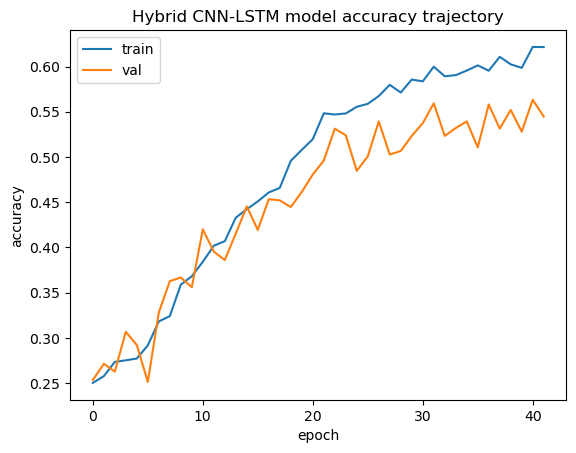

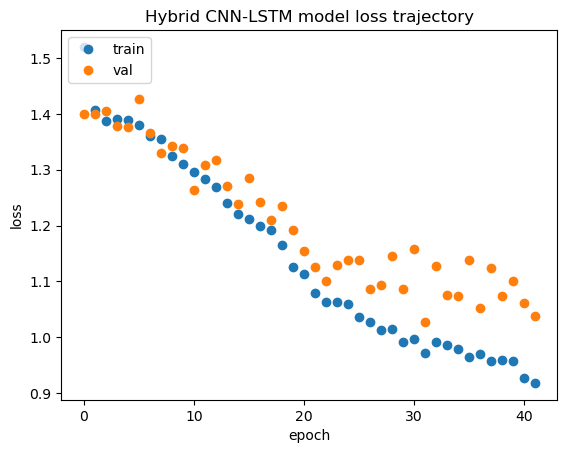

In [81]:
import matplotlib.pyplot as plt

print( hybrid_cnn_transformer_model_results.history['val_accuracy'][-1])
# Plotting accuracy trajectory
plt.plot(hybrid_cnn_transformer_model_results.history['accuracy'])
plt.plot(hybrid_cnn_transformer_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_transformer_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_transformer_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## (vii)(CNN-LSTM) Testing the performance of the hybrid CNN-LSTM model on the held out test set

In [83]:
## Testing the hybrid CNN-LSTM model

hybrid_cnn_transformer_score = hybrid_cnn_transformer_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the CNN Transformer model:',hybrid_cnn_transformer_score[1])

Test accuracy of the CNN Transformer model: 0.5874717831611633
